In [0]:
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install wordcloud

import re
import numpy as np
import pandas as pd
import folium
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import polyglot

from os import path
from PIL import Image
from itertools import cycle
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords as sw
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from polyglot.text import Text
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import svm

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

!polyglot download embeddings2.en
!polyglot download ner2.en

     |████████████████████████████████| 133kB 7.1MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52560 sha256=52f8fae572325b8e83f5997b404779cd3f7c2af7d96823ac200a0650f503389d
  Stored in directory: /root/.cache/pip/wheels/5e/91/ef/f1369fdc1203b0a9347d4b24f149b83a305f39ab047986d9da
Successfully built polyglot


###DESCRIPTIONs.txt
One per category

In [0]:
def category_desc_to_txt(df, category_list):
  
  #Collect all the descriptions in a text file, one per category(11)
  
  text = ['']*len(category_list)
  df_filtered_list = []
  counter = 0

  for category in category_list:
    df_filtered_list.append(df_train[df_train['CATEGORY'].str.contains(category)==True])

  for index in range(len(df_filtered_list)):
    for description in df_filtered_list[index].DESCRIPTION:
      text[index] = text[index] + ' ' + str(description)
      counter+=1
      if counter == int(report_1.shape[0]*split_rate):
        break

  category_list_names = []
  bad_chars = ['/', ' '] 

  for category in category_list:
    for i in bad_chars:
      category = category.replace(i, '')
    category_list_names.append(category.replace(i, ''))   

  for category, description in zip(category_list_names, text):
    f = open(category+'.txt',"w+")
    f.write(description)
    
  return category_list_names

In [0]:
#Read dataset and remove NA values
report_1 = pd.read_csv('Safety_GPS1.csv')
report_1 = report_1[pd.notna(report_1['DESCRIPTION'])]

#Category list extracted from harassment_risk_base.ipynb 
category_list = ['Touching /Groping','Catcalls/Whistles', 'Sexual Invites', 'Stalking', 'Others', 'Commenting',
                 'Rape / Sexual Assault', 'North East India Report', 'Indecent exposure', 'Chain Snatching', 
                 'Ogling/Facial Expressions/Staring', 'Taking pictures', 'Poor / No Street Lighting', 'Online Harassment']

#Split in train and test and create collections
split_rate = 0.8
df_train = report_1.iloc[0:int(report_1.shape[0]*split_rate), :].copy()
df_test = report_1.iloc[int(report_1.shape[0]*split_rate)+1:,: ].copy()
fileNames = category_desc_to_txt(df_train, category_list) 

### Tokenization + Lemmatization + Stemming
Top 20 most used words different outputs

In [0]:
def top20_and_allTokens(filename, stemming=True, lemmatization=True, plot=True):
  
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  category = open(filename, 'r')
  content = category.read().lower()
  pattern_wd_eng = (r'[A-Za-z]+') 
  
  print('\n', filename)
  
  #Tokenization
  tokens = re.findall(pattern_wd_eng, content)
  no_stops = [t for t in tqdm(tokens) if t not in sw.words('english')]
  
  print('Words and digits eng :\n', re.findall(pattern_wd_eng, content))
  print('\nSet() unique words and digits eng :\n', set(re.findall(pattern_wd_eng, content)))
  print('\nAfter nostop filter :\n', no_stops)
  
  top_20_a = Counter(no_stops).most_common(20)
  print('\nTop 20 most used words after non_stop:\n', top_20_a)
  
  #Lemmatization
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in no_stops]
  print('\nAfter lemmatizer :\n', lemmatized) if lemmatization else None
  top_20_b = Counter(lemmatized).most_common(20)
  print('\nTop 20 most used words after lemmatizer:\n', top_20_b) if lemmatization else None
  
  #Stemming
  stemmed = [stemmer.stem(word) for word in lemmatized]
  print('\nAfter stemmer :\n', stemmed) if stemming else None
  top_20 = Counter(stemmed).most_common(20)
  print('\nTop 20 most used words after stemmer:\n', top_20) if stemming else None
  
  top20_token = [word[0] for word in top_20]
  top20_count = [word[1] for word in top_20]
  
  if plot:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    plt.bar(labels, values, color='g')
    plt.show()
    
  total_tokens = lemmatized if lemmatization else no_stops
  total_tokens = stemmed if stemming else total_tokens
  
  return total_tokens

### Tf_idf

In [0]:
def top20_tf_idf(category_tokens):
  
  # Build a dicitionary with all the unique tokens merging all categories
  dictionary = Dictionary(category_tokens)

  # Corpus: List(7 items) of list(for each collection) of tuples of word_id and count
  corpus = [dictionary.doc2bow(collection) for collection in category_tokens]

  print('\ncorpus: {}'.format(len(corpus)))
  
  # Create a new TfidfModel using the corpus: tfidf
  tfidf = TfidfModel(corpus)

  print('Top_20 after Term Frequency–Inverse Document Frequency')  
  
  for index, tokens_and_Cnt in enumerate(corpus):
    print('\n', fileNames[index])
    
  # Calculate the tfidf weights of doc: tfidf_weights
    tfidf_weights = tfidf[tokens_and_Cnt]

  # Sort the weights from highest to lowest: sorted_tfidf_weights
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

  # Print the top 5 weighted words
    for term_id, weight in sorted_tfidf_weights[0:20]:
      print(dictionary.get(term_id), weight)
      
  return corpus, dictionary, tfidf

In [0]:
#With BOTH lemmatization and Stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)

In [0]:
#Without stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', stemming=False, plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)

In [0]:
#Without lemmatization nor stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', stemming=False, lemmatization=False, plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)

### Word Cloud
The first resulting Cloud is doesn't describe well the content of each category description, it's too general. tf-idf without lemmatization nor stemming performs better. Maybe if we apply a no_stop words filter without tokenizing it will perform better. The second resulting cloud doesn't carea about the order of the words (weights). Nevertheless, the word maps are unique

In [0]:
def WordCloud_gen(filename, corpus=corpus, corpus_index=0, dictionary=dictionary, tfidf=tfidf):
  
  stopwords_eng = sw.words("english")
  if filename=='tfidf':
    tfidf_weights = tfidf[corpus[corpus_index]]
    weights = [(dictionary[pair[0]], pair[1]) for pair in tfidf_weights]
    alice_mask = np.array(Image.open('silhouette.png'))
    wc = WordCloud(background_color="white", max_words=400, mask=alice_mask, stopwords=stopwords_eng)
    wc.generate_from_frequencies(dict(weights))
  else:
    category = open(filename +'.txt', 'r')
    content = category.read().lower() 
    alice_mask = np.array(Image.open('silhouette.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", max_words=400, mask=alice_mask, stopwords=stopwords_eng)
    wc.generate(content)

  plt.figure(figsize=(8,6), dpi=120)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
  return wc

In [0]:
#Without tfidf
WordCloud_gen('TouchingGroping')

In [0]:
#Third category WITH tfidf, can you guess it?
WordCloud_gen('tfidf', corpus_index=3)

In [0]:
#Can you guess it?
WordCloud_gen('tfidf', corpus_index=6)

### Name Entity Recognition NER

In [0]:
#Using nltk entities
category = open('TouchingGroping.txt', 'r')
content = category.read()

# Tokenize the article into sentences: sentences
sentences = nltk.sent_tokenize(content)

# Tokenize each sentence into words: token_sentences
token_sentences = [word_tokenize(sent) for sent in sentences]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = nltk.ne_chunk_sents(pos_sentences , binary=False)

# Test for stems of the tree with tags or NE tag
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label"):# and chunk.label() == "NE":
            print(chunk)

# NNP is proper-noun-singular

(ORGANIZATION Andheri/NNP Station/NNP)
(PERSON Mumbai/NNP)
(ORGANIZATION PEOPLE/NNP)
(PERSON Employee/NNP)
(PERSON Doctor/NNP)
(PERSON James/NNP)
(GPE Benedict/NNP)
(PERSON Faith/NNP)
(PERSON Eucabeth/NNP)
(ORGANIZATION Schillerstraße/NNP)
(GPE Bayerstraße/NNP)
(GPE North/NNP)
(GPE Pettenkoferstraße/NNP)
(GPE Sonnenstraße/NNP)
(PERSON Roshan/NNP Kumar/NNP)
(ORGANIZATION Technical/JJ)
(ORGANIZATION Global/NNP Foundries/NNP)
(GPE Boys/NNP)
(PERSON Isme/NNP)
(PERSON Mahatma/NNP)
(ORGANIZATION IIGJ/NNP)
(GPE Mahabaleshwar/NNP)
(GPE Bhekavali/NNP)
(GPE Bandra/NNP)
(ORGANIZATION SQUEEZE/NNP)
(GPE Was/NNP)
(GPE Number/NNP)
(GPE Bhekavali/NNP)
(GPE Mahabaleshwar/NNP)
(GPE Was/NNP)
(PERSON Experienced/NNP Touching/NNP)
(PERSON Experienced/NNP Beating/NNP)
(ORGANIZATION Incident/NNP)
(ORGANIZATION Incident/NNP)
(GPE Incident/NN)
(ORGANIZATION Incident/NNP)
(ORGANIZATION Incident/NNP)
(ORGANIZATION वकतपर/NNP)
(GPE Lausanne/NNP)
(GPE Geneva/NNP)
(GPE Was/NNP)
(GPE Perfect/JJ)
(ORGANIZATION Ganesh/

In [0]:
#Entity type participation
chunked_sentences = nltk.ne_chunk_sents(pos_sentences , binary=False)
ner_categories = defaultdict(int)

for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1

labels = list(ner_categories.keys())
print(labels)
values = [ner_categories.get(l) for l in labels]
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [0]:
#TODO loop over all categories, think how you are going to use this information
from spacy import displacy

#Using Spacy
category = open('TouchingGroping.txt', 'r')
content = category.read()

nlp = spacy.load('en')
nlp.entity
doc = nlp(content)
items = [x.text for x in doc.ents]
labels = [x.label_ for x in doc.ents]
labels_type =  np.unique(np.array(labels))
entity_dict = dict((k, []) for k in labels_type)

for item, label in zip(items, labels):
  entity_dict[label].append(item)

#print(entity_dict)
  
for ent_type in labels_type:
  #print('most_common {} entities: {}'.format(ent_type, Counter(entity_dict[ent_type]).most_common(5)))
  counter_ = Counter(entity_dict[ent_type])
  counter = Counter(entity_dict[ent_type]).most_common(5)
  top5_list = []
  top5 = ''
  for word_count in counter:
    word = word_count[0]
    if type(word) is str:
      top5 += ', ' + word if word.isalpha() else ''
      top5_list.append(word) if word.isalpha() else ''
  ##nlp = spacy.load("en_core_web_sm")
  ##doc = nlp(top5)
  top5_dict = dict((k, ['#']) for k in top5_list)
  ##print(top5_dict)
  #print(ent_type)
  #print(top5_list)
  #print(top5_dict)
  html = displacy.render(nlp('; '.join(top5_list)), style="ent", jupyter=True, manual=False) if len(top5_list)>0 else None
#Visualization (is this useful?)
#
#nlp = spacy.load("en")
#doc = nlp(top5_dict)
#html1 = displacy.render(top5_dict, style="ent", jupyter=True, manual=True)

In [0]:
text = 'hola'
print(type(text))
type(text) is str

### Multilingual NER with polyglot

In [0]:
#Using polyglot
#ptext = Text(content)
#entities = [(ent.tag, ' '.join(ent)) for ent in ptext.entities]
#print(entities)

### Supervised Text Classification
Using tf-idf feautures (weights) and word count

In [0]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

report_1 = pd.read_csv('Safety_GPS1.csv')
report_1 = report_1[pd.notna(report_1['DESCRIPTION'])]

#Select x and Y (without HumanTrafficking or PettyRobbery is til column 28)
x_report_1 = report_1[report_1.columns[4]]
y_report_1 = report_1[report_1.columns[14:28]]
X_train, X_test, y_train, y_test = train_test_split(x_report_1, y_report_1, test_size=0.2, random_state=17)
categories = y_train.columns

In [0]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

#TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [5]:
print(X_train.values[0])
print(count_train[0])

two boys commented on me and my sister while we were returning home from the market
  (0, 1144)	1
  (0, 1687)	1
  (0, 7208)	1
  (0, 6563)	1
  (0, 3616)	1
  (0, 4839)	1


In [0]:
#Hyperparameters preprocess

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

pattern_wd_eng = (r'[A-Za-z]+') 

lowers = [entry.lower() for entry in X_train.values] #1

def no_stopwords(dt_list, option=1):
  tokens = [re.findall(pattern_wd_eng, t) for t in dt_list] if option==1 else [word_tokenize(entry) for entry in dt_list]
  no_stops = [t for t in tokens if t not in sw.words('english')]
  return no_stops

In [0]:
no_stops = no_stopwords(lowers) #better
alternative = no_stopwords(lowers, option=2)

In [6]:
lemm = []
stemm = []
for category in tqdm(range(len(no_stops))):
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in no_stops[category]] #2
  lemm.append(lemmatized)
  stemmed = [stemmer.stem(word) for word in lemmatized] #3
  stemm.append(stemmed)

In [0]:
print(type(X_train))
print(stemm)
joint = [' '.join(stemm[t]) for t in range(len(stemm))]
joint2 = [' '.join(lemm[t]) for t in range(len(lemm))]
joint3 = [' '.join(lemm[t]) for t in range(len(no_stops))]
print(joint)
newX_train = pd.Series(joint)
newX_train2 = pd.Series(joint2)
newX_train3 = pd.Series(joint3)
newX_train4 = pd.Series(lowers)
print(newX_train)

In [0]:
# Check whether the two vectorizers are equal (They shouldn't be)
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)
print('Equality Test output: ', count_df.equals(tfidf_df))

Equality Test output:  False


Explain difference between OneVsRestClassifier and MultiOutputClassifier

####Naive Bayes
Next: SVM or linear models for tf-idf; create a function to iterate over the alphas from 0 to 1 with steps 0.1 with np.arange()

In [0]:
#Initial test for one category, CountVectorizer()
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train.iloc[:,0])
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test.iloc[:,0], pred)
print('Test accuracy is {}'.format(score))
metrics.confusion_matrix(y_test.iloc[:,0], pred)

Test accuracy is 0.8611488014473089


array([[1497,   80],
       [ 227,  407]])

In [0]:
#Initial test for one category, TfidfVectorizer()
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train.iloc[:,0])
pred = nb_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test.iloc[:,0], pred)
print('Test accuracy is {}'.format(score))
metrics.confusion_matrix(y_test.iloc[:,0], pred, labels=[0,1])

In [0]:
#Inspecting the model
# Get the class labels: class_labels
class_labels = nb_classifier.classes_
# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()
# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))
print(class_labels, feat_with_weights[300:350])

[0 1] [(-10.512709498158312, 'aren'), (-10.512709498158312, 'arena'), (-10.512709498158312, 'ares'), (-10.512709498158312, 'arested'), (-10.512709498158312, 'arguing'), (-10.512709498158312, 'arival'), (-10.512709498158312, 'armbushed'), (-10.512709498158312, 'armed'), (-10.512709498158312, 'army'), (-10.512709498158312, 'arre'), (-10.512709498158312, 'arrest'), (-10.512709498158312, 'arrested'), (-10.512709498158312, 'arrival'), (-10.512709498158312, 'arrives'), (-10.512709498158312, 'arriving'), (-10.512709498158312, 'arterial'), (-10.512709498158312, 'article'), (-10.512709498158312, 'artid'), (-10.512709498158312, 'artificial'), (-10.512709498158312, 'arts'), (-10.512709498158312, 'aruvathimuvar'), (-10.512709498158312, 'asgarali'), (-10.512709498158312, 'ashok'), (-10.512709498158312, 'asians'), (-10.512709498158312, 'aside'), (-10.512709498158312, 'asif'), (-10.512709498158312, 'aso'), (-10.512709498158312, 'aspx'), (-10.512709498158312, 'assassinating'), (-10.512709498158312, 'a

In [0]:
#Pipelines
NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')), 
                        ('clf', OneVsRestClassifier(MultinomialNB())),])
NB_pipeline_TfidfV = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                        ('clf', OneVsRestClassifier(MultinomialNB())),])
NB_pipeline_CountV2 = Pipeline([('count2', CountVectorizer(stop_words='english')), 
                        ('clf', MultiOutputClassifier(MultinomialNB())),]) #do tuning for this one as well

In [0]:
#For OneVsRestClasifier strategy
from sklearn.metrics import precision_recall_fscore_support

def execute(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):

  accuracies=[]
  for category in (tqdm(categories) if verbose else categories):
    pipeline.fit(X_train, y_train[category])
    prediction = pipeline.predict(X_test)
    
    if len(X_test) == 1:
      print('Prediction for {} is {}'.format(category, prediction)) if verbose else None
    else:
      print('Test accuracy for {} is {}'.format(category, metrics.accuracy_score(y_test[category], prediction))) if verbose else None
      accuracies.append(metrics.accuracy_score(y_test[category], prediction))
      print(metrics.confusion_matrix(y_test[category], prediction, labels=[0,1])) if confusion_matrix else None
      print('precision_recall_fscore_support_weighted', precision_recall_fscore_support(y_test[category], prediction, average='weighted')) if verbose else None
      
  print('mean: ', sum(accuracies)/len(accuracies)) if verbose else None
  return accuracies

def execute_mean(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):

  accuracies=[]
  for category in (tqdm(categories) if verbose else categories):
    pipeline.fit(X_train, y_train[category])
    prediction = pipeline.predict(X_test)
    
    if len(X_test) == 1:
      print('Prediction for {} is {}'.format(category, prediction)) if verbose else None
    else:
      print('Test accuracy for {} is {}'.format(category, metrics.accuracy_score(y_test[category], prediction))) if verbose else None
      accuracies.append(metrics.accuracy_score(y_test[category], prediction))
      print(metrics.confusion_matrix(y_test[category], prediction, labels=[0,1])) if confusion_matrix else None
      print('precision_recall_fscore_support_weighted', precision_recall_fscore_support(y_test[category], prediction, average='weighted')) if verbose else None
  
  mean = sum(accuracies)/len(accuracies)
  print('mean: ', mean) if verbose else None
  return accuracies, mean

In [0]:
#For MultOutputClasifier strategy
def execute2(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):

  #TODO:output the accuracy per category or its equivalent
  
  accuracies=[]
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  
  #for index, category in enumerate(categories):
    #print('Test accuracy for {} is {}'.format(category, metrics.accuracy_score(y_test[index], y_pred[index])))
      
  if confusion_matrix:
    y_test_list = y_test.values.tolist()
    y_test_array = np.array(y_test_list)
    y_pred_list = y_pred.tolist()
    y_pred_array = np.array(y_pred_list)
    conf_mat = metrics.multilabel_confusion_matrix(y_test_array, y_pred_array)
    print('Test accuracy is {}'.format(metrics.accuracy_score(y_test_array, y_pred_array)))
    print(conf_mat)
      
  return accuracies

In [69]:
acc = execute(NB_pipeline_CountV, confusion_matrix=False)

Test accuracy for Touching /Groping is 0.8611488014473089
Test accuracy for Catcalls/Whistles is 0.8132066938037087
Test accuracy for Sexual Invites is 0.8941655359565808
Test accuracy for Stalking is 0.9199457259158752
Test accuracy for Others is 0.8891904115784712
Test accuracy for Commenting is 0.7815468113975577
Test accuracy for Rape / Sexual Assault is 0.9493441881501583
Test accuracy for North East India Report is 0.9950248756218906
Test accuracy for Indecent Exposure/Masturbation in public is 0.942107643600181
Test accuracy for Chain Snatching is 0.9787426503844414
Test accuracy for Ogling/Facial Expressions/Staring is 0.8227046585255541
Test accuracy for Taking pictures is 0.9434644957033017
Test accuracy for Poor / No Street Lighting is 0.9701492537313433
Test accuracy for Online Harassment is 0.9990954319312528



In [64]:
acc = execute(NB_pipeline_CountV, X_train=newX_train, confusion_matrix=False) #

Test accuracy for Touching /Groping is 0.7747625508819539
Test accuracy for Catcalls/Whistles is 0.7530529172320217
Test accuracy for Sexual Invites is 0.8864767073722297
Test accuracy for Stalking is 0.9154228855721394
Test accuracy for Others is 0.8742650384441429
Test accuracy for Commenting is 0.6625961103573044
Test accuracy for Rape / Sexual Assault is 0.9439167797376753
Test accuracy for North East India Report is 0.9950248756218906
Test accuracy for Indecent Exposure/Masturbation in public is 0.9303482587064676
Test accuracy for Chain Snatching is 0.979194934418815
Test accuracy for Ogling/Facial Expressions/Staring is 0.7892356399819086
Test accuracy for Taking pictures is 0.9208502939846224
Test accuracy for Poor / No Street Lighting is 0.9669832654907282
Test accuracy for Online Harassment is 0.9990954319312528



In [66]:
acc = execute(NB_pipeline_CountV, X_train=newX_train2, confusion_matrix=False) #with just lemm is worse

Test accuracy for Touching /Groping is 0.7860696517412935
Test accuracy for Catcalls/Whistles is 0.76797829036635
Test accuracy for Sexual Invites is 0.8869289914066033
Test accuracy for Stalking is 0.9167797376752601
Test accuracy for Others is 0.8815015829941203
Test accuracy for Commenting is 0.6910900045228403
Test accuracy for Rape / Sexual Assault is 0.947535052012664
Test accuracy for North East India Report is 0.9954771596562642
Test accuracy for Indecent Exposure/Masturbation in public is 0.9371325192220714
Test accuracy for Chain Snatching is 0.9782903663500678
Test accuracy for Ogling/Facial Expressions/Staring is 0.798733604703754
Test accuracy for Taking pictures is 0.9226594301221167
Test accuracy for Poor / No Street Lighting is 0.9669832654907282
Test accuracy for Online Harassment is 0.9990954319312528



In [68]:
acc = execute(NB_pipeline_CountV, X_train=newX_train3, confusion_matrix=False) #with just no_stopwords

Test accuracy for Touching /Groping is 0.7860696517412935
Test accuracy for Catcalls/Whistles is 0.76797829036635
Test accuracy for Sexual Invites is 0.8869289914066033
Test accuracy for Stalking is 0.9167797376752601
Test accuracy for Others is 0.8815015829941203
Test accuracy for Commenting is 0.6910900045228403
Test accuracy for Rape / Sexual Assault is 0.947535052012664
Test accuracy for North East India Report is 0.9954771596562642
Test accuracy for Indecent Exposure/Masturbation in public is 0.9371325192220714
Test accuracy for Chain Snatching is 0.9782903663500678
Test accuracy for Ogling/Facial Expressions/Staring is 0.798733604703754
Test accuracy for Taking pictures is 0.9226594301221167
Test accuracy for Poor / No Street Lighting is 0.9669832654907282
Test accuracy for Online Harassment is 0.9990954319312528



In [13]:
acc = execute(NB_pipeline_CountV, X_train=newX_train4, confusion_matrix=True) #with just lowers the output is the sme

Test accuracy for Touching /Groping is 0.8611488014473089
[[1497   80]
 [ 227  407]]
Test accuracy for Catcalls/Whistles is 0.8132066938037087
[[1559  133]
 [ 280  239]]
Test accuracy for Sexual Invites is 0.8941655359565808
[[1940   38]
 [ 196   37]]
Test accuracy for Stalking is 0.9199457259158752
[[2002   27]
 [ 150   32]]
Test accuracy for Others is 0.8891904115784712
[[1925   26]
 [ 219   41]]
Test accuracy for Commenting is 0.7815468113975577
[[1166  206]
 [ 277  562]]
Test accuracy for Rape / Sexual Assault is 0.9493441881501583
[[2067   25]
 [  87   32]]
Test accuracy for North East India Report is 0.9950248756218906
[[2200    3]
 [   8    0]]
Test accuracy for Indecent Exposure/Masturbation in public is 0.942107643600181
[[2063    8]
 [ 120   20]]
Test accuracy for Chain Snatching is 0.9787426503844414
[[2116   11]
 [  36   48]]
Test accuracy for Ogling/Facial Expressions/Staring is 0.8227046585255541
[[1653   81]
 [ 311  166]]
Test accuracy for Taking pictures is 0.9434644957

In [12]:
acc = execute2(NB_pipeline_CountV2, confusion_matrix=True) #the sme onevsrest

Test accuracy is 0.30574400723654455
[[[1497   80]
  [ 227  407]]

 [[1559  133]
  [ 280  239]]

 [[1940   38]
  [ 196   37]]

 [[2002   27]
  [ 150   32]]

 [[1925   26]
  [ 219   41]]

 [[1166  206]
  [ 277  562]]

 [[2067   25]
  [  87   32]]

 [[2200    3]
  [   8    0]]

 [[2063    8]
  [ 120   20]]

 [[2116   11]
  [  36   48]]

 [[1653   81]
  [ 311  166]]

 [[2027   12]
  [ 113   59]]

 [[2119   11]
  [  55   26]]

 [[2209    2]
  [   0    0]]]


In [0]:
acc = execute(NB_pipeline_TfidfV)

Test accuracy for Touching /Groping is 0.80958842152872
Test accuracy for Catcalls/Whistles is 0.8018995929443691
Test accuracy for Sexual Invites is 0.8959746720940751
Test accuracy for Stalking is 0.919041157847128
Test accuracy for Others is 0.8864767073722297
Test accuracy for Commenting is 0.7697874265038445
Test accuracy for Rape / Sexual Assault is 0.9461781999095432
Test accuracy for North East India Report is 0.9963817277250113
Test accuracy for Indecent Exposure/Masturbation in public is 0.937584803256445
Test accuracy for Chain Snatching is 0.9674355495251018
Test accuracy for Ogling/Facial Expressions/Staring is 0.798733604703754
Test accuracy for Taking pictures is 0.9253731343283582
Test accuracy for Poor / No Street Lighting is 0.9656264133876075
Test accuracy for Online Harassment is 1.0



In [0]:
test_string = [""""He started rubbing my shoulders, telling me I looked stressed. Then he went down in my shirt. 
                  He walked around the living room area and he came back. That is when he touched my breast.
                  Then he grabbed my waist of my pants and also grabbed my hair as I tried to leave. I made it to the door and left.
                  It happened so quickly. I was just trying to get out of the townhouse"""]

acc = execute(NB_pipeline_CountV, X_test = test_string)
acc = execute(NB_pipeline_TfidfV,  X_test = test_string)

Prediction for Touching /Groping is [1]
Prediction for Catcalls/Whistles is [0]
Prediction for Sexual Invites is [0]
Prediction for Stalking is [0]
Prediction for Others is [0]
Prediction for Commenting is [0]
Prediction for Rape / Sexual Assault is [0]
Prediction for North East India Report is [0]
Prediction for Indecent Exposure/Masturbation in public is [0]
Prediction for Chain Snatching is [0]
Prediction for Ogling/Facial Expressions/Staring is [0]
Prediction for Taking pictures is [0]
Prediction for Poor / No Street Lighting is [0]
Prediction for Online Harassment is [0]



Prediction for Touching /Groping is [1]
Prediction for Catcalls/Whistles is [0]
Prediction for Sexual Invites is [0]
Prediction for Stalking is [0]
Prediction for Others is [0]
Prediction for Commenting is [0]
Prediction for Rape / Sexual Assault is [0]
Prediction for North East India Report is [0]
Prediction for Indecent Exposure/Masturbation in public is [0]
Prediction for Chain Snatching is [0]
Prediction for Ogling/Facial Expressions/Staring is [0]
Prediction for Taking pictures is [0]
Prediction for Poor / No Street Lighting is [0]
Prediction for Online Harassment is [0]



#####Hyperparameter Tuning
alpha : Increase the probablities of all bigrams in your non-maximum likelihood equation (Since we are changing the counts from what they occurred in hopes to make it better) by 1 to make everything non-zero. That increase by 1 is called adding the pseudocount or as you know it as α. Now, α=1 may not always give the most accurate probablities and hence they could attain any finite non-negative integer. The way to know what α gives the most accurate responses is through iterating over all values of α on the training set unfortunately

In [0]:
#Hyperparameter Tuning CountVectorizer
alphas_out = []

for alpha in tqdm(np.arange(0,1,0.05)):
  NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')),
                                 ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None, alpha=alpha))),])
  acc = execute(NB_pipeline_CountV, verbose=False)
  alphas_out.append(acc)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

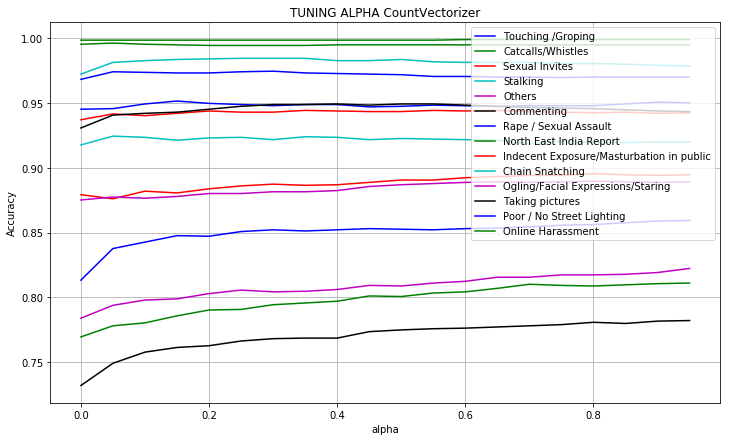

In [0]:
cycol = cycle('bgrcmk')
accuracies = []
plt.figure(figsize=(12,7))

for category in range(len(categories)):
  for alpha in alphas_out:
    accuracies.append(alpha[category])

  alpha_array = np.arange(0.0,1.0,0.05)
  plt.plot(alpha_array, accuracies, c=next(cycol))
  plt.xlabel('alpha')
  plt.ylabel('Accuracy')
  plt.title('TUNING ALPHA CountVectorizer')
  accuracies = []
  
plt.gca().legend(categories, loc='upper right')  
plt.grid()  
plt.show()

In [0]:
#Hyperparameter Tuning TfidfVectorizer
alphas_out = []

for alpha in tqdm(np.arange(0,1,0.05)):
  NB_pipeline_TfidfV = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                                 ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None, alpha=alpha))),])
  acc = execute(NB_pipeline_TfidfV, verbose=False)
  alphas_out.append(acc)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

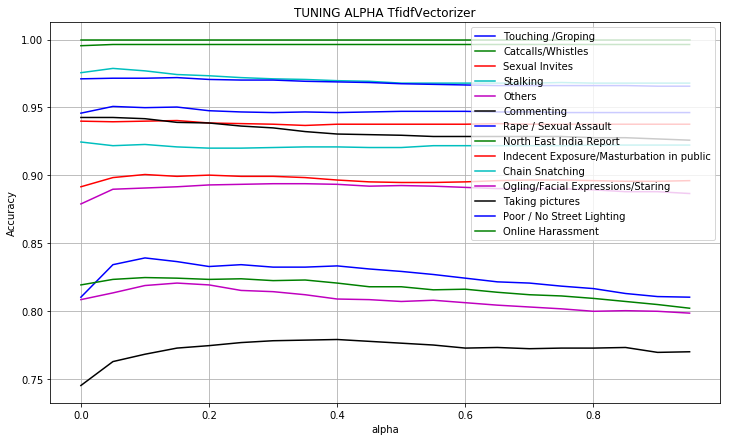

In [0]:
# todo: lowest-accuracy-shortlist with categories to plot a zoom to the revelant accuracy improvements

cycol = cycle('bgrcmk')
accuracies = []
plt.figure(figsize=(12,7))

for category in range(len(categories)):
  for alpha in alphas_out:
    accuracies.append(alpha[category])

  alpha_array = np.arange(0.0,1.0,0.05)
  plt.plot(alpha_array, accuracies, c=next(cycol))
  plt.xlabel('alpha')
  plt.ylabel('Accuracy')
  plt.title('TUNING ALPHA TfidfVectorizer')
  accuracies = []

plt.gca().legend(categories, loc='upper right') 
plt.grid()  
plt.show()

So for 'tf-idf' alpha optimal (smoothing) = 0.3; for 'count' alpha is 1 (as expected). SVM could work better for tf-idf.

####Support Vector Machine

In [14]:
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(LinearSVC()))])

acc = execute(SVM_pipeline, verbose=True)

#cheif if tf-idf transform is equal to tf-idf vectorizer

#conf_mat = confusion_matrix(y_test, y_pred)
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=categories, yticklabels=categories)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show()

Test accuracy for Touching /Groping is 0.8593396653098145
Test accuracy for Catcalls/Whistles is 0.8299412030755314
Test accuracy for Sexual Invites is 0.9054726368159204
Test accuracy for Stalking is 0.9280868385345997
Test accuracy for Others is 0.8860244233378561
Test accuracy for Commenting is 0.7919493441881501
Test accuracy for Rape / Sexual Assault is 0.9592944369063772
Test accuracy for North East India Report is 0.9968340117593849
Test accuracy for Indecent Exposure/Masturbation in public is 0.9479873360470376
Test accuracy for Chain Snatching is 0.9868837630031659
Test accuracy for Ogling/Facial Expressions/Staring is 0.8208955223880597
Test accuracy for Taking pictures is 0.9565807327001357
Test accuracy for Poor / No Street Lighting is 0.9751243781094527
Test accuracy for Online Harassment is 1.0



#####Hyperparameter Tuning

In [0]:
#Hyperparameter Tuning SVM
#Note: c, threshold djustment, enconde, n-grms, coef0, shrinking missing

from sklearn import svm

acc_dict = {}
kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6]

for c in tqdm(cs):
  for kernel in kernels:
    print('\nSVC with kernel = {}, gamma = auto, c = {}'.format(kernel, c))
    SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                    ('tfidf', TfidfTransformer()),
                                    ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma='auto', C=c)))])
    acc_k, m_k = execute_mean(SVM_pipeline_kernel, verbose=False)
    acc_dict.update({kernel+'_auto_'+str(c):m_k})

    if kernel != 'linear':
      for gamma in gammas: 
        if kernel == 'poly':
          for degree in degrees:
            print('\nSVC with kernel = {}, gamma = {}, c = {} and degree = {}'.format(kernel, gamma, c, degree))
            SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma=gamma, C=c, degree=degree)))])
            acc_kgd, m_kgd = execute_mean(SVM_pipeline_kernel, verbose=False)
            acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c)+'_'+str(degree):m_kgd})

        else:
          print('\nSVC with kernel = {}, c = {} and gamma = {}'.format(kernel, c, gamma))
          SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, C=c, gamma=gamma)))])
          acc_kg, m_kg = execute_mean(SVM_pipeline_kernel, verbose=False)
          acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c):m_kg})


SVC with kernel = linear, gamma = auto, c = 0.1

SVC with kernel = rbf, gamma = auto, c = 0.1

SVC with kernel = rbf, c = 0.1 and gamma = scale

SVC with kernel = rbf, c = 0.1 and gamma = 0.1

SVC with kernel = rbf, c = 0.1 and gamma = 1

SVC with kernel = rbf, c = 0.1 and gamma = 10

SVC with kernel = rbf, c = 0.1 and gamma = 100

SVC with kernel = poly, gamma = auto, c = 0.1

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 0

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 1

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 2

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 3

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 4

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 5

SVC with kernel = poly, gamma = scale, c = 0.1 and degree = 6

SVC with kernel = poly, gamma = 0.1, c = 0.1 and degree = 0

SVC with kernel = poly, gamma = 0.1, c = 0.1 and degree = 1

SVC with kernel = poly, gamma = 0.1, c = 0.1 and degree

In [17]:
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(svm.SVC(kernel='linear', gamma='auto', C=1.0)))])

acc = execute(SVM_pipeline, verbose=True)

Test accuracy for Touching /Groping is 0.8683853459972863
precision_recall_fscore_support_weighted (0.8684271467151216, 0.8683853459972863, 0.8616125545209374, None)
Test accuracy for Catcalls/Whistles is 0.8403437358661239
precision_recall_fscore_support_weighted (0.8428692901583692, 0.8403437358661239, 0.8160778364089479, None)
Test accuracy for Sexual Invites is 0.9054726368159204
precision_recall_fscore_support_weighted (0.8929826717402044, 0.9054726368159204, 0.8759274231155673, None)
Test accuracy for Stalking is 0.9357756671189507
precision_recall_fscore_support_weighted (0.9270302368734259, 0.9357756671189507, 0.9237332189256853, None)
Test accuracy for Others is 0.8959746720940751
precision_recall_fscore_support_weighted (0.898105709696034, 0.8959746720940751, 0.8594374979294781, None)
Test accuracy for Commenting is 0.8136589778380823
precision_recall_fscore_support_weighted (0.8158081874009054, 0.8136589778380823, 0.807631176621091, None)
Test accuracy for Rape / Sexual Assa

####Models Comparison

In [0]:
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(LinearSVC()))])

acc_SVM = execute(SVM_pipeline, verbose=True)

NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')), 
                        ('clf', OneVsRestClassifier(MultinomialNB())),])

acc_NB = execute(NB_pipeline_CountV, verbose=True)

Test accuracy for Touching /Groping is 0.8593396653098145
Test accuracy for Catcalls/Whistles is 0.8299412030755314
Test accuracy for Sexual Invites is 0.9054726368159204
Test accuracy for Stalking is 0.9280868385345997
Test accuracy for Others is 0.8860244233378561
Test accuracy for Commenting is 0.7919493441881501
Test accuracy for Rape / Sexual Assault is 0.9592944369063772
Test accuracy for North East India Report is 0.9968340117593849
Test accuracy for Indecent Exposure/Masturbation in public is 0.9479873360470376
Test accuracy for Chain Snatching is 0.9868837630031659
Test accuracy for Ogling/Facial Expressions/Staring is 0.8208955223880597
Test accuracy for Taking pictures is 0.9565807327001357
Test accuracy for Poor / No Street Lighting is 0.9751243781094527
Test accuracy for Online Harassment is 1.0



Test accuracy for Touching /Groping is 0.8611488014473089
Test accuracy for Catcalls/Whistles is 0.8132066938037087
Test accuracy for Sexual Invites is 0.8941655359565808
Test accuracy for Stalking is 0.9199457259158752
Test accuracy for Others is 0.8891904115784712
Test accuracy for Commenting is 0.7815468113975577
Test accuracy for Rape / Sexual Assault is 0.9493441881501583
Test accuracy for North East India Report is 0.9950248756218906
Test accuracy for Indecent Exposure/Masturbation in public is 0.942107643600181
Test accuracy for Chain Snatching is 0.9787426503844414
Test accuracy for Ogling/Facial Expressions/Staring is 0.8227046585255541
Test accuracy for Taking pictures is 0.9434644957033017
Test accuracy for Poor / No Street Lighting is 0.9701492537313433
Test accuracy for Online Harassment is 0.9990954319312528



In [0]:
#Helper function for coloring negatives in pandas DataFrame

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [0]:
df_acc_SVM = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_SVM)), orient='index')
df_acc_NB = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_NB)), orient='index')
compare = pd.concat([df_acc_SVM, df_acc_NB], axis=1)
compare.columns = ['Acc SVM', 'Acc NB']
compare['SVM advantage'] = compare['Acc SVM'] - compare['Acc NB']
compare['%'] = (compare['SVM advantage']*100).round(1)
compare.style.applymap(color_negative_red)

,Acc SVM,Acc NB,SVM advantage,%
Touching /Groping,0.85934,0.861149,-0.00180914,-0.2
Catcalls/Whistles,0.829941,0.813207,0.0167345,1.7
Sexual Invites,0.905473,0.894166,0.0113071,1.1
Stalking,0.928087,0.919946,0.00814111,0.8
Others,0.886024,0.88919,-0.00316599,-0.3
Commenting,0.791949,0.781547,0.0104025,1
Rape / Sexual Assault,0.959294,0.949344,0.00995025,1
North East India Report,0.996834,0.995025,0.00180914,0.2
Indecent Exposure/Masturbation in public,0.947987,0.942108,0.00587969,0.6
Chain Snatching,0.986884,0.978743,0.00814111,0.8


###N-grams

In [0]:
#We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
#source: https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/

from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:]

###Los Angeles dataset

In [0]:
report_1 = pd.read_csv('la_crime_2012-2016.csv')
report_1 = report_1[pd.notna(report_1['crime_description'])]
print(report_1.head())
print('shape of the complete dataset: ', report_1.shape)

x_report_1 = report_1[report_1.columns[8]]
##y_report_1 = report_1[report_1.columns[14:30]] #including human_traficking and petty_robbery
#From string comma-separated to boolean
categories=[]
counter = 0

for index, row in tqdm(report_1.iterrows()):
    counter+=1
    cat_group_list = [i for i in row.category.split(',')]
    del(cat_group_list[-1])
    for category in cat_group_list:
      category = [category.lstrip()]
      if category not in categories:
        categories.append(category) #add a new category
      else:
        next
    #replace in the original df with the list. iat[] is to set a single row and 5 is the CATEGORY column index    
    report_1.iat[index, 8] = cat_group_list #CORRECT THIS!!!
    
print("Total number of unique categories : {}\n".format(len(categories)))

#y_report_1 = report_1[report_1.columns[14:28]]
#y_report_1_one = report_1[report_1.columns[14]]
#df_report_1 = pd.concat([x_report_1, y_report_1], axis=1, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(x_report_1, y_report_1, test_size=0.2, random_state=17)
#count_vectorizer = CountVectorizer(stop_words='english') #or TfidfVectorizer(stop_words="english", max_df=0.7)
#count_train = count_vectorizer.fit_transform(X_train.values)
#count_test = count_vectorizer.transform(X_test.values)
#print(count_vectorizer.get_feature_names()[:20])
#print(count_train.A[:5]) #.A attribute is array